# EDA Prelim results
- Removing Region 1, Tester name, and Taster twitter handle.
- Removing rows with null entries in description, designation, variety, winery, title.
- Removing rows with null entries in province- they also have null entries for region_1
- A large share wines in the dataset comes from the US (especially California).
- Some popular grape types are Pinor Noir, Chardonnay, Red Blend, Cabernet Sauvignon.

- Most wines in our data has only 1 review --> potential bias if we want to use these reviews to predict the exact wine.

    - 91% of wine titles has only 1 review - these reviews make up 83% of review data
    
    - 60% of wine designations has only 1 review - these reviews make up 75% of review data

- In case we use the Classification approach, check if a wine style has sufficient number of reviews. I consider 3 defitions for style: *province-variety*, *province-variety with modifications*, and *country-variety with modifications*. 

    - *province-variety* 
        - If we discards all style with < 80 reviews, we retain 80% of review data. 
        - This yields 169 styles, with a mean review counts for each style being 379 reviews.
        - California groups still dominate, still too many classes (169)
    -  *province-variety with mod* 
        - If we discards all style with < 80 reviews, we retain 60% of review data. 
        - This yields 196 styles, with a mean review counts for each style being 274 reviews.
        - Too many classes (196)
    -  *country-variety with mod* seems to be a better definition 
        - If we discards all style with < 200 reviews, we retain 60% of review data. 
        - This yields 86 styles, with a mean review counts for each style being 580 reviews.
        - --> Choose this style definition for Classification
        
- Check some meta features of the reviews to ensure they are not to short or too long to be chopped off by the transformer algorithms. 
    - Almost half of the reviews have character count > 256 --> will be chopped off when entering 'all-MiniLM-L6-v2' embedding model.

- Visualize some most common words: 'flavor', 'fruit', 'finish', 'palate', 'acidity'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string 
import re
import spacy

To read csv file in a different directory - Copied the path by the *copy path* option in the right click of that file. Replace forward slash \ with / or \\ or (r"C:\... path of the file")

In [73]:
wine = pd.read_csv('../Data/Raw Data/winemag-data-130k-v2.csv', encoding='utf-8')
wine.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Data cleaning

### Drop duplicated rows

In [74]:
wine.drop_duplicates(wine.columns[1:], keep='first', inplace=True, ignore_index=True)

### Clean up 'region_1' variable

In [75]:
# Replace 'region_1' with 'province' if NA
wine['region_1'].mask(wine['region_1'].isna(), wine['province'], inplace=True)

# Remove the word "County" in column 'region_1'
wine['region_1b'] = wine['region_1'].str.replace('County', '')
wine['region_1b'] = wine['region_1b'].str.replace(' -', '-')
wine['region_1b'] = wine['region_1b'].str.strip()

# Group by 'province' and 'region_1b', then drop colum 'id' in the goup-by table since it's a placeholder column to perform groupby
reg_top3prov = wine[wine['province'].isin(['California', 'Washington', 'Oregon']) ].groupby(['province', 'region_1b']).id.count().reset_index()
reg_top3prov.drop('id', axis=1, inplace=True)

# California
ca_reg = reg_top3prov[reg_top3prov['province']=='California' ].copy()
ca_reg['region_1c'] = reg_top3prov[reg_top3prov['province']=='California' ]['region_1b'].\
                        apply(lambda x:  '-'.join(sorted(list(set(x.split('-'))))) )
ca_reg['region_1c'].mask(ca_reg['region_1c']=='Mt. Harlan', 'Mount Harlan', inplace=True)

# Washington
wa_reg = reg_top3prov[reg_top3prov['province']=='Washington' ].copy()
wa_reg['region_1c'] = wa_reg['region_1b']
wa_reg['region_1c'].mask(wa_reg['region_1c']=='Columbia Valley', 'Columbia Valley (WA)', inplace=True)
wa_reg['region_1c'].mask(wa_reg['region_1c']=='Columbia Valley-Walla Walla Valley', 'Walla Walla Valley (WA)', inplace=True)


In [76]:
# Merge CA regions back to wine dataset
wine = wine.merge(ca_reg, how='left', on=['province', 'region_1b'] )
wine['region_1b'].mask(~wine['region_1c'].isna(), wine['region_1c'], inplace=True) 
wine.drop(['region_1c'], axis=1, inplace=True)

In [77]:
# Merge WA regions back to wine dataset
wine = wine.merge(wa_reg, how='left', on=['province', 'region_1b'] )
wine['region_1b'].mask(~wine['region_1c'].isna(), wine['region_1c'], inplace=True) 
wine.drop(['region_1c'], axis=1, inplace=True)

In [78]:
# Oregon: keep 'Willamette Valley', 'Dundee Hills', 'Chehalem Mountains' in 'region_1b'
# change all other regions to 'Oregon Other'
# wine['region_1c'] = wine['region_1b']
wine['region_1b'].mask((~wine['region_1b'].isin(['Willamette Valley', 'Dundee Hills', 'Chehalem Mountains']) 
                        & (wine['province']=='Oregon') ), 
                       'Oregon Other', inplace=True) 

# Rename 'region_1b' as 'region_cleaned'
wine.rename(columns={'region_1b': 'region_cleaned'}, inplace=True)
wine.columns

Index(['id', 'country', 'description', 'designation', 'points', 'price',
       'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery',
       'region_cleaned'],
      dtype='object')

### Clean up 'province' variable

In [79]:
# Replace 'province' with 'region_cleaned' if province==NA
wine['province'].mask(wine['province'].isna(), wine['region_cleaned'], inplace=True)


### Change dtypes of 'points' and 'price'

In [80]:
# Change dtypes of 'points' and 'price'
wine['points'] = wine['points'].astype('float')
wine['price'] = wine['price'].astype('float')

### Remove Unnecessary Columns

Removing Region 1, Tester name, and Taster twitter handle.

In [81]:
wine.drop(['region_2','taster_name','taster_twitter_handle'], axis=1, inplace = True)

### Removing Rows with NaN entries

Removing rows with null entries in the description, designation, variety, winery, title.

 The *dropna()* method removes all rows that contain null values in the specified column.


In [82]:
wine.dropna(subset=['description','designation','title','variety','winery', 'country'], inplace=True)
# Note: all reviews with 'country' == NA also have NA values for 'province' and 'region'

### Check 'title' columm - how many reviews per title?

In [83]:
# No missing title
wine['title'].isnull().values.any()

False

Now we want to make sure we have enough reviews per wine variety!

In [84]:
print(wine['title'].value_counts())

title
Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                         9
Segura Viudas NV Extra Dry Sparkling (Cava)                                    7
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                        7
Ruinart NV Brut Rosé  (Champagne)                                              6
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)                           6
                                                                              ..
Northfield 2007 Home Creek Vineyard Pinot Noir (Waipara)                       1
Nino Franco 2007 Rive di San Floriano Brut  (Prosecco di Valdobbiadene)        1
Monte Rossa 2003 Cabochon Brut Sparkling (Franciacorta)                        1
Rainer Wess 2007 Terrassen Riesling (Wachau)                                   1
Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)    1
Name: count, Length: 84502, dtype: int64


In [85]:
# Check how many wine titles have only 1 reviews --> 83% of reviews describe 1 unique wine title
tab_by_title = wine.groupby('title')['id'].count().reset_index()
tab_by_title.rename(columns={'id':'count'}, inplace=True)
tab_by_title.sort_values('count', ascending=False, inplace=True)
tab_by_title['tot_count'] = tab_by_title['count'].sum()
tab_by_title['share'] = tab_by_title['count']/tab_by_title['tot_count']
tab_by_title['share_cum'] = tab_by_title['share'].cumsum()

display(tab_by_title[tab_by_title['count']>1].tail()) # 1-0.16824 = 0.83176

,title,count,tot_count,share,share_cum
68693,Schramsberg NV Mirabelle Brut Sparkling (North...,2,85394,0.000023,0.018327
10845,Ca'Romè 2010 Cerretta (Barolo),2,85394,0.000023,0.018350
42862,Juvé y Camps NV Sweet Reserva Sparkling (Cava),2,85394,0.000023,0.018374
50034,Maison Champy 2010 Signature (Bourgogne),2,85394,0.000023,0.018397
36535,Gosset 1998 Celebris Vintage Extra Brut (Cham...,2,85394,0.000023,0.018420


In [86]:
print('Share of wine titles with at least 2 reviews:', len(tab_by_title[tab_by_title['count']>=2])/len(tab_by_title))
print('Share of wine titles with at least 5 reviews:', len(tab_by_title[tab_by_title['count']>=5])/len(tab_by_title))

Share of wine titles with at least 2 reviews: 0.0080589808525242
Share of wine titles with at least 5 reviews: 0.0002248467491893683


In [87]:
# Check how many wine designations have only 1 review --> 25% of reviews describe 1 unique wine designation
# Check how many wine designations have less than 5 reviews --> 65% of reviews describe 1 unique wine designation
tab_by_desig = wine.groupby('designation')['id'].count().reset_index()
tab_by_desig.rename(columns={'id':'count'}, inplace=True)
tab_by_desig.sort_values('count', ascending=False, inplace=True)
tab_by_desig['tot_count'] = tab_by_desig['count'].sum()
tab_by_desig['share'] = tab_by_desig['count']/tab_by_desig['tot_count']
tab_by_desig['share_cum'] = tab_by_desig['share'].cumsum()

display(tab_by_desig[tab_by_desig['count']>5].tail()) # 1-0.368171 = 0.631829
display(tab_by_desig[tab_by_desig['count']>2].tail()) # 1-0.591583 = 0.408417
display(tab_by_desig[tab_by_desig['count']>1].tail()) # 1-0.753065 = 0.2469

,designation,count,tot_count,share,share_cum
29536,SV Estate,6,85394,0.00007,0.348865
10743,Dos Rubios Vineyard,6,85394,0.00007,0.348936
22384,Modus,6,85394,0.00007,0.349006
26705,Pur Plaisir,6,85394,0.00007,0.349076
4187,Branco Reserva,6,85394,0.00007,0.349146


,designation,count,tot_count,share,share_cum
37605,Yverdon Vineyard,3,85394,0.000035,0.558107
1491,Anderson Family Vineyard,3,85394,0.000035,0.558142
4330,Bricco dell'Uccellone,3,85394,0.000035,0.558177
37921,Équinoxe,3,85394,0.000035,0.558213
35755,Vigna Fiego,3,85394,0.000035,0.558248


,designation,count,tot_count,share,share_cum
9551,Daisy,2,85394,0.000023,0.707673
6544,Château Beaulieu,2,85394,0.000023,0.707696
20979,Lynette,2,85394,0.000023,0.707720
37512,Y Block,2,85394,0.000023,0.707743
9536,Da Vinci,2,85394,0.000023,0.707766


In [88]:
print('Share of wine designations with at least 2 reviews:', len(tab_by_desig[tab_by_desig['count']>=2])/len(tab_by_desig))
print('Share of wine designations with at least 5 reviews:', len(tab_by_desig[tab_by_desig['count']>=5])/len(tab_by_desig))

Share of wine designations with at least 2 reviews: 0.34249354481741057
Share of wine designations with at least 5 reviews: 0.06544764715181535


### Create columns 'style1', 'style2', 'style3'

In [89]:
wine['style1'] = wine['variety'] + ' - ' + wine['province']

wine['style2'] = wine['style1']
wine['style2'].mask( wine['province'].isin(['California', 'Oregon']), wine['variety'] + ' - ' + wine['region_cleaned'] , inplace=True)

# wine['style3'] = wine['variety'] + ' - ' + wine['province'] + ' - ' + wine['winery']
wine['style3'] = wine['variety'] + ' - ' + wine['country']
wine['style3'].mask( wine['country'].isin(['US']), wine['variety'] + ' - ' + wine['province'] , inplace=True)
wine['style3'].mask( wine['province'].isin(['California', 'Oregon']), wine['variety'] + ' - ' + wine['region_cleaned'] , inplace=True)


# Concatenate reviews of the same wine 'title'

In [90]:
# Count the number of reviews per title
wine['title_count'] = wine.groupby('title')['id'].transform('count')

# Subset titles with multiple reviews
mult_revs = wine[wine['title_count']>1].sort_values(['title', 'id']).copy()

# Create a column to index the reviews wihtin each title
mult_revs['_n'] = mult_revs.groupby('title').cumcount()+1

# Change dtypes of 'points' and 'price'
mult_revs['points'] = mult_revs['points'].astype('float')
mult_revs['price'] = mult_revs['price'].astype('float')

# Get the number of columns that would result after reshape wide
max_n_revs_per_title = mult_revs['_n'].max()

In [91]:
# Reshape wide mult_revs --> get reviews in columns and each title is a row
mult_revs_wide = mult_revs.pivot(index='title', values=['description', 'points', 'price'], columns='_n').reset_index()
mult_revs_wide.columns = [mult_revs_wide.columns[0][0]] + mult_revs_wide.columns[1:].map('{0[0]}_{0[1]}'.format).to_list()

# Replace NAs in 'description' cols with empty string
mult_revs_wide[mult_revs_wide.columns[1:max_n_revs_per_title+1]] = mult_revs_wide[mult_revs_wide.columns[1:max_n_revs_per_title+1]].fillna('')

# Concatenate reviews
mult_revs_wide['rev_mult'] =  mult_revs_wide[mult_revs_wide.columns[1:max_n_revs_per_title+1]].apply(lambda x: ' '.join(x), axis=1)
mult_revs_wide['rev_mult'] = mult_revs_wide['rev_mult'].str.strip()

# Average price and points
mult_revs_wide['points_mult'] =  mult_revs_wide[mult_revs_wide.columns[max_n_revs_per_title+1:max_n_revs_per_title*2+1]].mean(axis=1)
mult_revs_wide['price_mult'] = mult_revs_wide[mult_revs_wide.columns[max_n_revs_per_title*2+1:max_n_revs_per_title*3+1]].mean(axis=1)

# Keep only the long review
mult_revs_wide = mult_revs_wide[['title', 'rev_mult', 'points_mult', 'price_mult']]

# Change dtypes of 'points' and 'price'
mult_revs_wide['points_mult'] = mult_revs_wide['points_mult'].astype('float')
mult_revs_wide['price_mult'] = mult_revs_wide['price_mult'].astype('float')

In [92]:
# Merge the long review back to wine df
wine_rev_concat = wine.merge(mult_revs_wide, how='left', on='title')

In [93]:
# Replace column 'description' with 'rev_long'
wine_rev_concat['description'].mask(wine_rev_concat['title_count']>1, wine_rev_concat['rev_mult'], inplace=True)
wine_rev_concat['points'].mask(wine_rev_concat['title_count']>1, wine_rev_concat['points_mult'], inplace=True)
wine_rev_concat['price'].mask(wine_rev_concat['title_count']>1, wine_rev_concat['price_mult'], inplace=True)

# Drop duplicated 'title'
wine_rev_concat.drop_duplicates(subset='title', keep='first', inplace=True)

# drop columns
wine_rev_concat.drop(columns=['rev_mult', 'points_mult', 'price_mult', 'title_count', 'region_1'], inplace=True)

# Save dataset

In [94]:
# Save wine_clean dataset
# drop columns
wine.drop(columns=['title_count', 'region_1'], inplace=True)
wine.to_csv('../Data/Cleaned Data/wine_cleaned.csv', index=False)

In [95]:
# Save wine_cleaned_rev_concat dataset
wine_rev_concat.to_csv('../Data/Cleaned Data/wine_cleaned_rev_concat.csv', index=False)

# Visualization

## Check distribution of countries

First, let's look at the **distribution of countries** with the help of pie-chart.

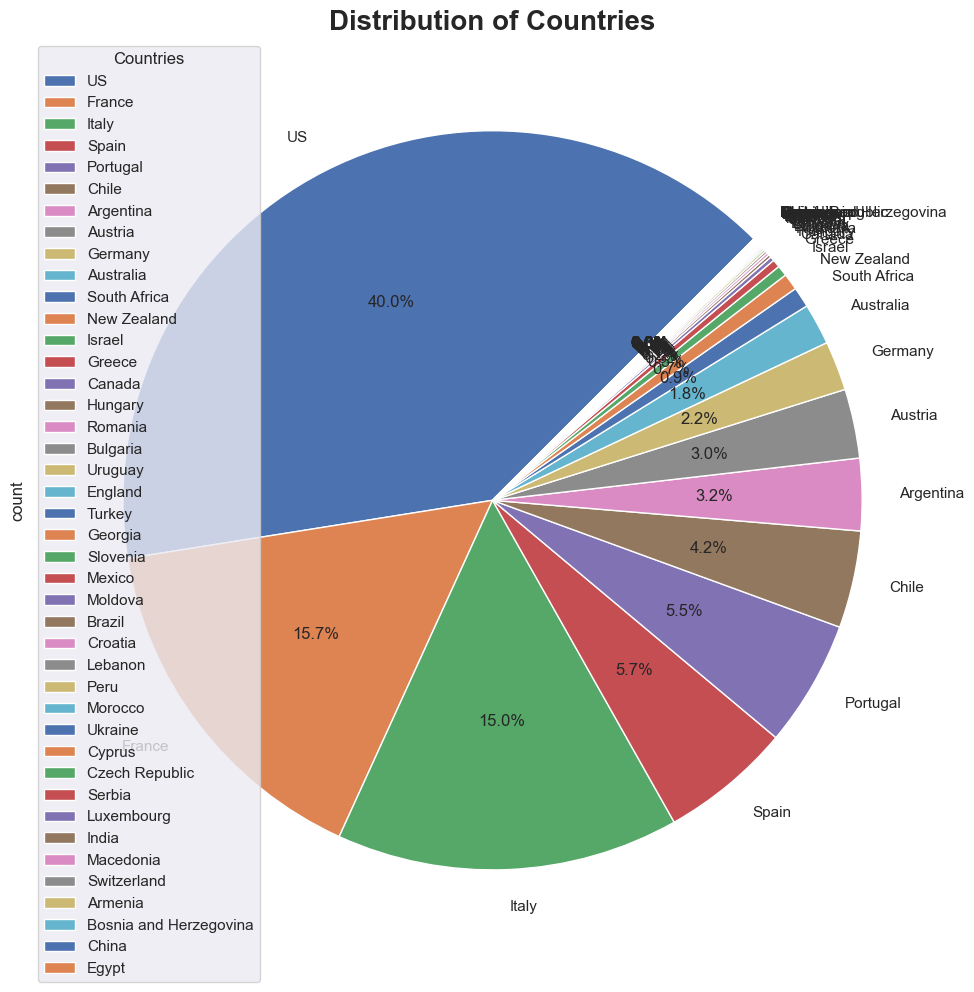

In [96]:
fig = plt.figure(figsize=(12,12))
number_countries = wine['country'].value_counts()
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
plt.legend(title="Countries")
plt.title("Distribution of Countries", fontsize ='20', fontweight = 'bold')
plt.show()

## Check distribution of variety (grape type)

Now, let's look at the **Distribution of variety (grape type)**

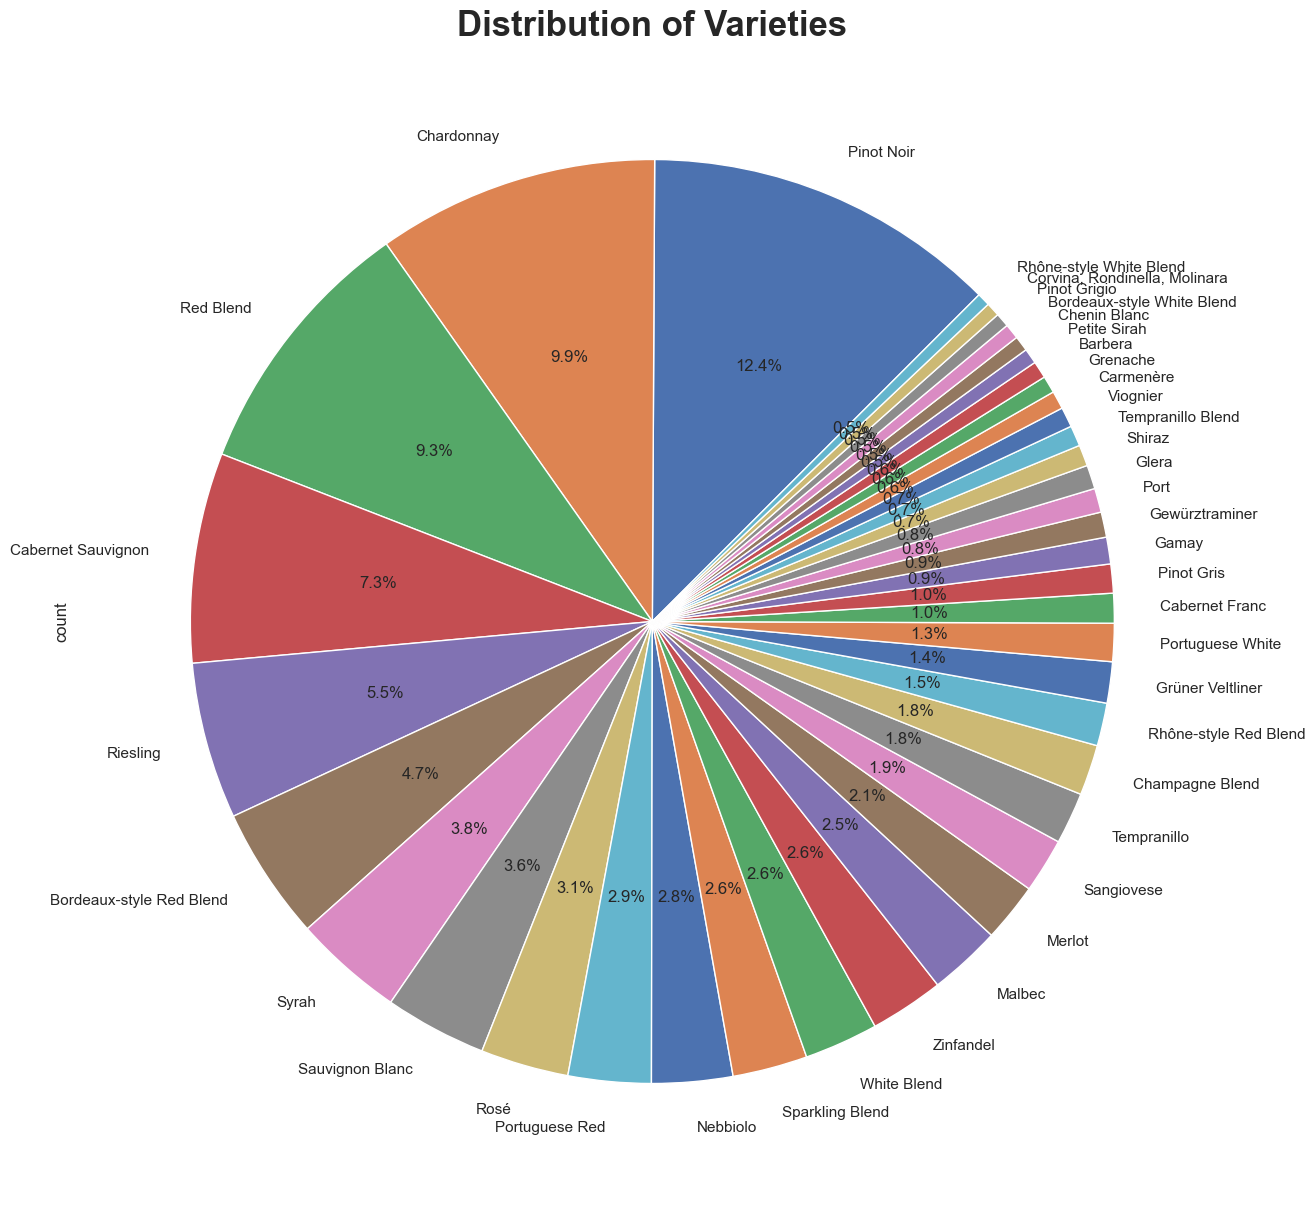

In [97]:
fig = plt.figure(figsize=(15,15))
number_countries = wine['variety'].value_counts()[:40]
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
# plt.legend(title="Varieties")
plt.title("Distribution of Varieties", fontsize ='25', fontweight = 'bold')
plt.show()

## Check distribution of province

Finally, **Distribution of Province** 

In [98]:
province = wine['province'].value_counts()
province

province
California                 22611
Washington                  5433
Oregon                      3486
Tuscany                     3429
Northern Spain              2846
                           ...  
Ceres Plateau                  1
Pafos                          1
Mostar                         1
Mátra                          1
Vin de Pays de Velvendo        1
Name: count, Length: 406, dtype: int64

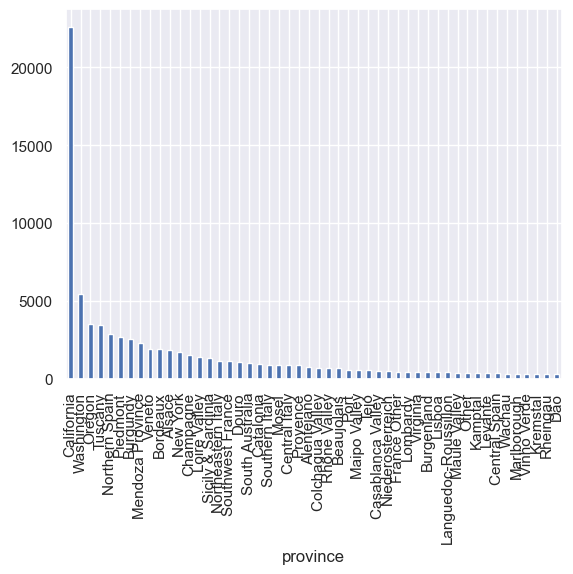

In [99]:
wine['province'].value_counts()[:50].plot(kind = 'bar')
plt.show()

## Check wine *style* definition

In [100]:
# Define bar_chart_top20 function with seaborn styling
def bar_chart_top20(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,4))
    sns.countplot(y = var_name, 
                  data = data,
                  order = data[var_name].value_counts(ascending=False).index[0:20]) 
    plt.title(f'Number of reviews per {var_name}') 
    plt.show()
    return 

# Define bar_chart_top50 function with seaborn styling
def bar_chart_top50(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,10))
    sns.countplot(y = var_name, 
                  data = data,
                  order = data[var_name].value_counts(ascending=False).index[0:50]) 
    plt.title(f'Number of reviews per {var_name}') 
    plt.show()
    return 

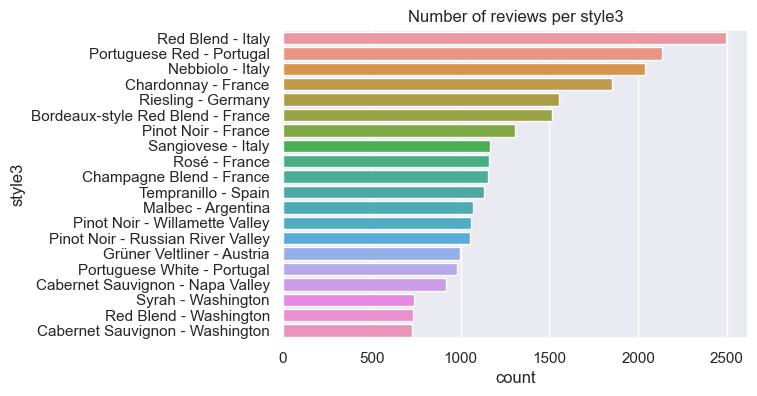

In [101]:
# bar_chart_top20(wine, 'style1') # some styles in California is very large (b/c California makes up a huge share in the dataset)
# bar_chart_top20(wine, 'style2') ## pretty good
bar_chart_top20(wine, 'style3') # too fine, many categories will have too few reviews

In [102]:
# Check how much of the sample is left if drop wine style with less than 80 reviews --> 80% of sample
tab_by_style1 = wine.groupby('style1')['id'].count().reset_index()
tab_by_style1.rename(columns={'id':'count'}, inplace=True)
tab_by_style1.sort_values('count', ascending=False, inplace=True)
tab_by_style1['tot_count'] = tab_by_style1['count'].sum()
tab_by_style1['share'] = tab_by_style1['count']/tab_by_style1['tot_count']
tab_by_style1['share_cum'] = tab_by_style1['share'].cumsum()

display(tab_by_style1[tab_by_style1['count']>=80].tail())
print('Mean review count per style =', tab_by_style1[tab_by_style1['count']>=80]['count'].mean())
print('Number of styles (classes)', len(tab_by_style1[tab_by_style1['count']>=80]))


,style1,count,tot_count,share,share_cum
1896,Pinot Noir - New York,84,85394,0.000984,0.746645
3356,Viognier - Washington,82,85394,0.000960,0.747605
139,Blaufränkisch - Burgenland,82,85394,0.000960,0.748565
2060,Primitivo - Southern Italy,82,85394,0.000960,0.749526
1102,Grenache - Washington,81,85394,0.000949,0.750474


Mean review count per style = 379.20710059171597
Number of styles (classes) 169


In [103]:
# Check how much of the sample is left if drop wine style2 with less than 80 reviews --> 60% of sample
tab_by_style2 = wine.groupby('style2')['id'].count().reset_index()
tab_by_style2.rename(columns={'id':'count'}, inplace=True)
tab_by_style2.sort_values('count', ascending=False, inplace=True)
tab_by_style2['tot_count'] = tab_by_style2['count'].sum()
tab_by_style2['share'] = tab_by_style2['count']/tab_by_style2['tot_count']
tab_by_style2['share_cum'] = tab_by_style2['share'].cumsum()

display(tab_by_style2[tab_by_style2['count']>=80].tail())
print('Mean review count per style =', tab_by_style2[tab_by_style2['count']>=80]['count'].mean())
print('Number of styles (classes)', len(tab_by_style2[tab_by_style2['count']>=80]))


,style2,count,tot_count,share,share_cum
5000,Viognier - Washington,82,85394,0.000960,0.625477
3029,Primitivo - Southern Italy,82,85394,0.000960,0.626437
179,Blaufränkisch - Burgenland,82,85394,0.000960,0.627398
1584,Grenache - Washington,81,85394,0.000949,0.628346
2789,Pinot Noir - Monterey,80,85394,0.000937,0.629283


Mean review count per style = 274.1683673469388
Number of styles (classes) 196


In [104]:
# Check how much of the sample is left if drop wine style3 with less than 80 reviews --> 60% of sample
tab_by_style3 = wine.groupby('style3')['id'].count().reset_index()
tab_by_style3.rename(columns={'id':'count'}, inplace=True)
tab_by_style3.sort_values('count', ascending=False, inplace=True)
tab_by_style3['tot_count'] = tab_by_style2['count'].sum()
tab_by_style3['share'] = tab_by_style2['count']/tab_by_style2['tot_count']
tab_by_style3['share_cum'] = tab_by_style2['share'].cumsum()

display(tab_by_style3[tab_by_style3['count']>=200].tail())
print('Mean review count per style =', tab_by_style3[tab_by_style3['count']>=200]['count'].mean())
print('Number of styles (classes)', len(tab_by_style3[tab_by_style3['count']>=200]))


,style3,count,tot_count,share,share_cum
2087,Prosecco - Italy,215,85394,0.000012,0.997435
741,Chardonnay - Sonoma Coast,211,85394,0.000023,0.965220
1844,Pinot Grigio - Italy,209,85394,0.000012,0.985046
1357,Merlot - Chile,202,85394,0.000281,0.791227
2104,Red Blend - Argentina,202,85394,0.000023,0.972996


Mean review count per style = 580.8372093023256
Number of styles (classes) 86


In [109]:
print('Style = province x variety, number of classes =', len(wine['style1'].unique()))
print('Style = province x variety with mod, number of classes =', len(wine['style2'].unique()))
print('Style = country x variety (non-US)\n\tprovince x variety (US, except CA and OR)\n\tregion x variety ( CA and OR),\n\tnumber of classes =', len(wine['style3'].unique()))

print('Style = province x variety, number of classes if drop classes <80 reviews =',len(tab_by_style1[tab_by_style1['count']>=80]))
print('Style = province x variety with mod, number of classes if drop classes <80 reviews =', len(tab_by_style2[tab_by_style2['count']>=80]))
print('Style = province x variety with mod, number of classes if drop classes <200 reviews =', len(tab_by_style3[tab_by_style3['count']>=200]))

Style = province x variety, number of classes = 3575
Style = province x variety with mod, number of classes = 5349
Style = country x variety (non-US)
	province x variety (US, except CA and OR)
	region x variety ( CA and OR),
	number of classes = 3616
Style = province x variety, number of classes if drop classes <80 reviews = 169
Style = province x variety with mod, number of classes if drop classes <80 reviews = 196
Style = province x variety with mod, number of classes if drop classes <200 reviews = 86


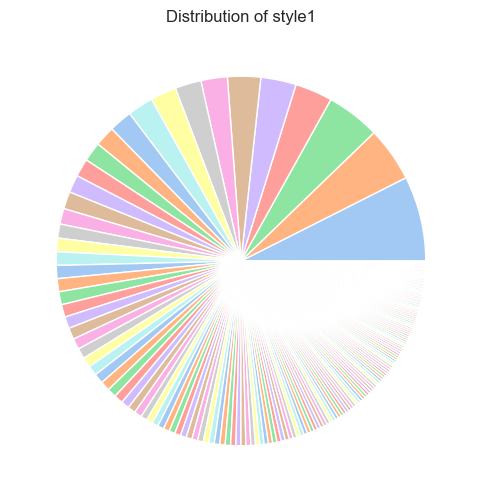

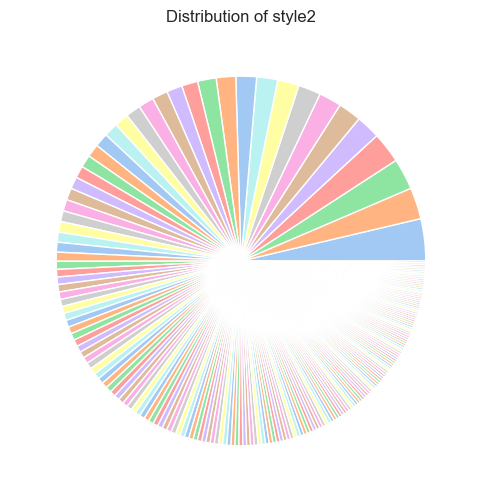

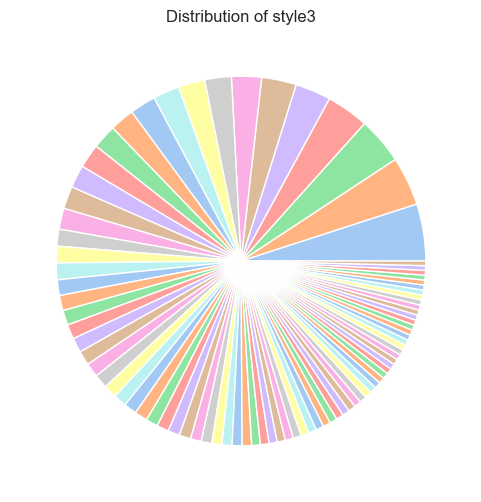

In [111]:
# Define pie_chart function with seaborn styling
def pie_chart(data, var_name, name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,6))
    colors = sns.color_palette("pastel", n_colors=len(data))
    plt.pie(data=data, x=var_name, colors=colors)
    plt.title(f'Distribution of {name}') 
    plt.show()
    return 


# Check the relative size of each class (style)
pie_chart(tab_by_style1[tab_by_style1['count']>=80], 'count', 'style1')
pie_chart(tab_by_style2[tab_by_style2['count']>=80], 'count', 'style2')
pie_chart(tab_by_style3[tab_by_style3['count']>=200], 'count', 'style3')


## Check meta features of reviews

**word count**, unique word count, stop word count, mean word length ,character count, punctuation count

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
word_count = [ len(r.split()) for r in wine['description'] ]
unique_word_count = wine['description'].apply(lambda x: len(set(x.split())))
#  [ len(set(r.split())) for r in wine['description']] 
stop_word_count = wine['description'].apply(lambda x: len(set(x.split()) & STOP_WORDS))
mean_word_length = wine['description'].apply(lambda x: sum(map(len, x.split()))/len(x.split()) )
character_count = wine['description'].apply(lambda x: len(x.replace(' ',''))) # exclusing space
punctuation_count = wine['description'].apply(lambda x: len(re.findall(f'[{string.punctuation}]', x)))

In [ ]:
meta_list = [word_count, 
             unique_word_count,
             stop_word_count, 
             mean_word_length,
             character_count, 
             punctuation_count]
meta_features = pd.DataFrame(meta_list).T
meta_features.columns = ['word_count', 
                         'unique_word_count',
                         'stop_word_count', 
                         'mean_word_length',
                         'character_count', 
                         'punctuation_count']

In [ ]:
# Check min and max word counts
print('min word count = ', meta_features.word_count.min())
print('max word count = ', meta_features.word_count.max())

In [ ]:
# Define histogram function with seaborn styling
def hist_plot(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,4))
    sns.histplot(data=data, x=var_name)
    plt.title(f'Histogram of {var_name}') 
    plt.show()
    return ax

In [ ]:
for f in meta_features:
    hist_plot(meta_features, f)

## Polular N-grams

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load("en_core_web_sm")


In [91]:
to_remove = [c for c in string.punctuation]
to_remove.append('wine')

In [92]:
# Unigrams
def tokenize_lemma(text):
    return [w.lemma_.lower() for w in nlp(text)]

stop_words_lemma = list(tokenize_lemma(' '.join(STOP_WORDS)))

unigr_counter = CountVectorizer(max_features=50, 
                                tokenizer = tokenize_lemma,
                                stop_words = stop_words_lemma) 

wine_1gram = unigr_counter.fit_transform(wine['description'] )
wine_1gram_df = pd.DataFrame(wine_1gram.toarray(), columns=unigr_counter.get_feature_names_out())

# remove punctuation characters + the word 'wine' since it's not helpful
wine_1gram_df = wine_1gram_df.loc[:, ~wine_1gram_df.columns.isin(to_remove)] 

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn(


In [93]:
# Bigrams
bigr_counter = CountVectorizer(max_features=50, 
                             ngram_range=(2,2), 
                             stop_words=list(STOP_WORDS) )

wine_2gram = bigr_counter.fit_transform( wine['description']  )
wine_2gram_df = pd.DataFrame(wine_2gram.toarray(), columns=bigr_counter.get_feature_names_out())

# remove punctuation characters
wine_2gram_df = wine_2gram_df.loc[:, ~wine_2gram_df.columns.isin(set(to_remove))] 

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [94]:
# Trigrams
trigr_counter = CountVectorizer(max_features=50, 
                             ngram_range=(3,3), 
                             stop_words=list(STOP_WORDS) )

wine_3gram = trigr_counter.fit_transform( wine['description']  )
wine_3gram_df = pd.DataFrame(wine_3gram.toarray(), columns=trigr_counter.get_feature_names_out())

# remove punctuation characters
wine_3gram_df = wine_3gram_df.loc[:, ~wine_3gram_df.columns.isin(set(to_remove))]

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [95]:
# Check global list of names associated with wine_3gram_df
[name for name in globals() if globals()[name] is wine_3gram_df]

['wine_3gram_df']

In [96]:
# Define function to print out name of an object
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# Define bar_chart_top_ngrams function with seaborn styling
def bar_chart_top_ngrams(data):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,10))
    collapsed_df = data.sum(axis=0).reset_index()
    collapsed_df.columns = ['ngram', 'count']
    collapsed_df.sort_values('count', ascending=False, inplace=True)
    df_plotted = namestr(data, globals())
    sns.barplot(collapsed_df, x='count', y='ngram', hue='ngram', legend=False) 
    plt.title(f'Counts per n-gram, {df_plotted}') 
    plt.show()
    return ax

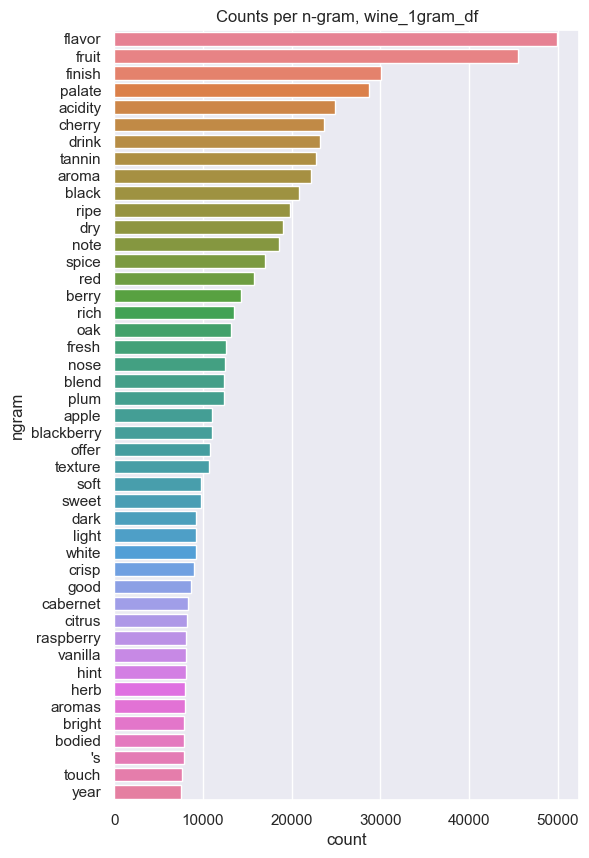

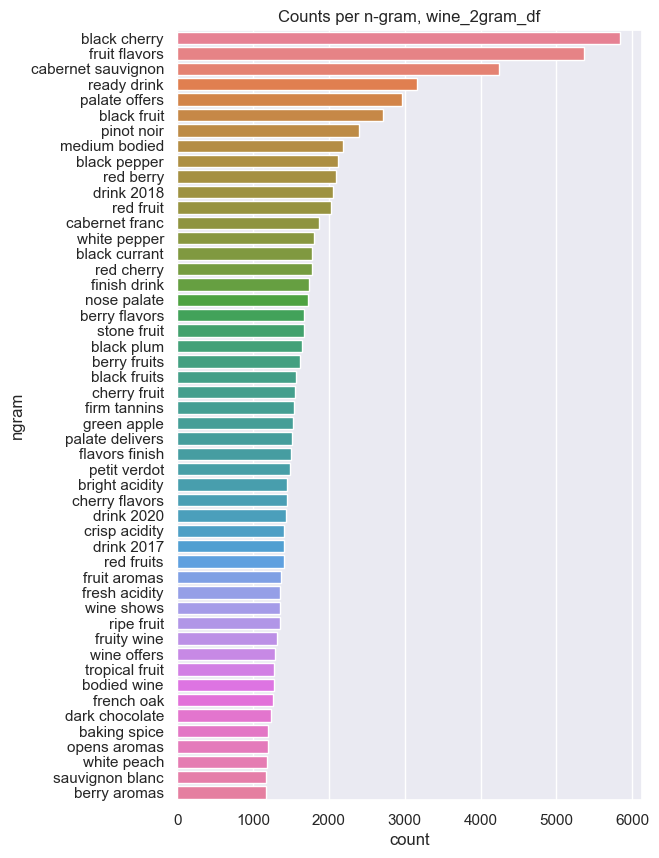

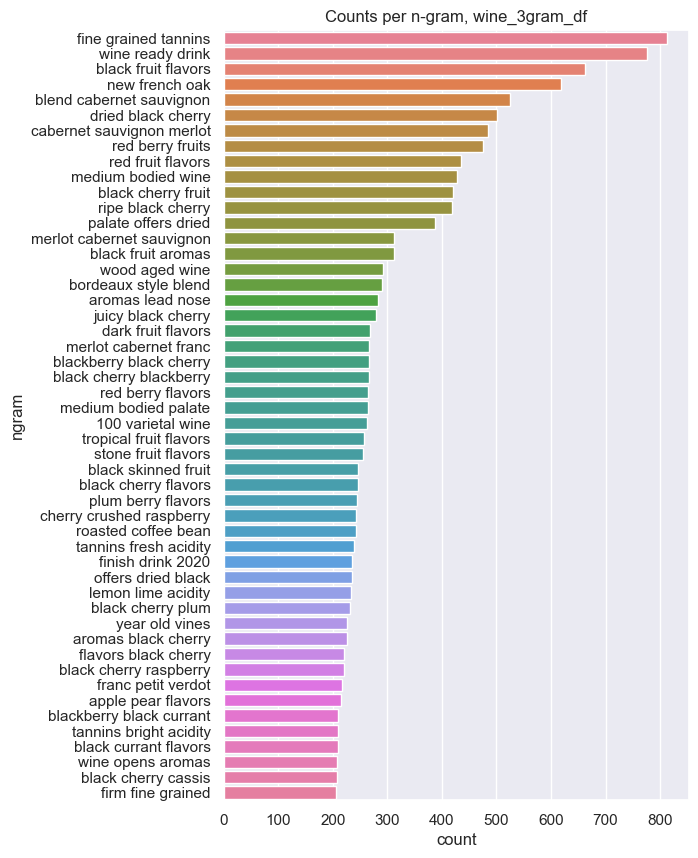

In [97]:
ngram_df_list = [wine_1gram_df, wine_2gram_df, wine_3gram_df]

for df in ngram_df_list:
    bar_chart_top_ngrams(df)


# PCA Visualization of text embeddings

In [4]:
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
# Load wine_cleaned_rev_concat dataset
wine_rev_concat =  pd.read_csv('../Data/Cleaned Data/wine_cleaned_rev_concat.csv')

In [10]:
embeddings = torch.load("../Data/description_embeddings_openai_ada-002.pt")
# labels are just the wine id's
vector_labels = wine_rev_concat.id.astype(str).tolist()

In [11]:
# Scale the embddings
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings.numpy()) 

In [12]:
# Apply PCA to all vectors
pca = PCA(n_components=2)
transformed_vectors = pca.fit_transform(embeddings)

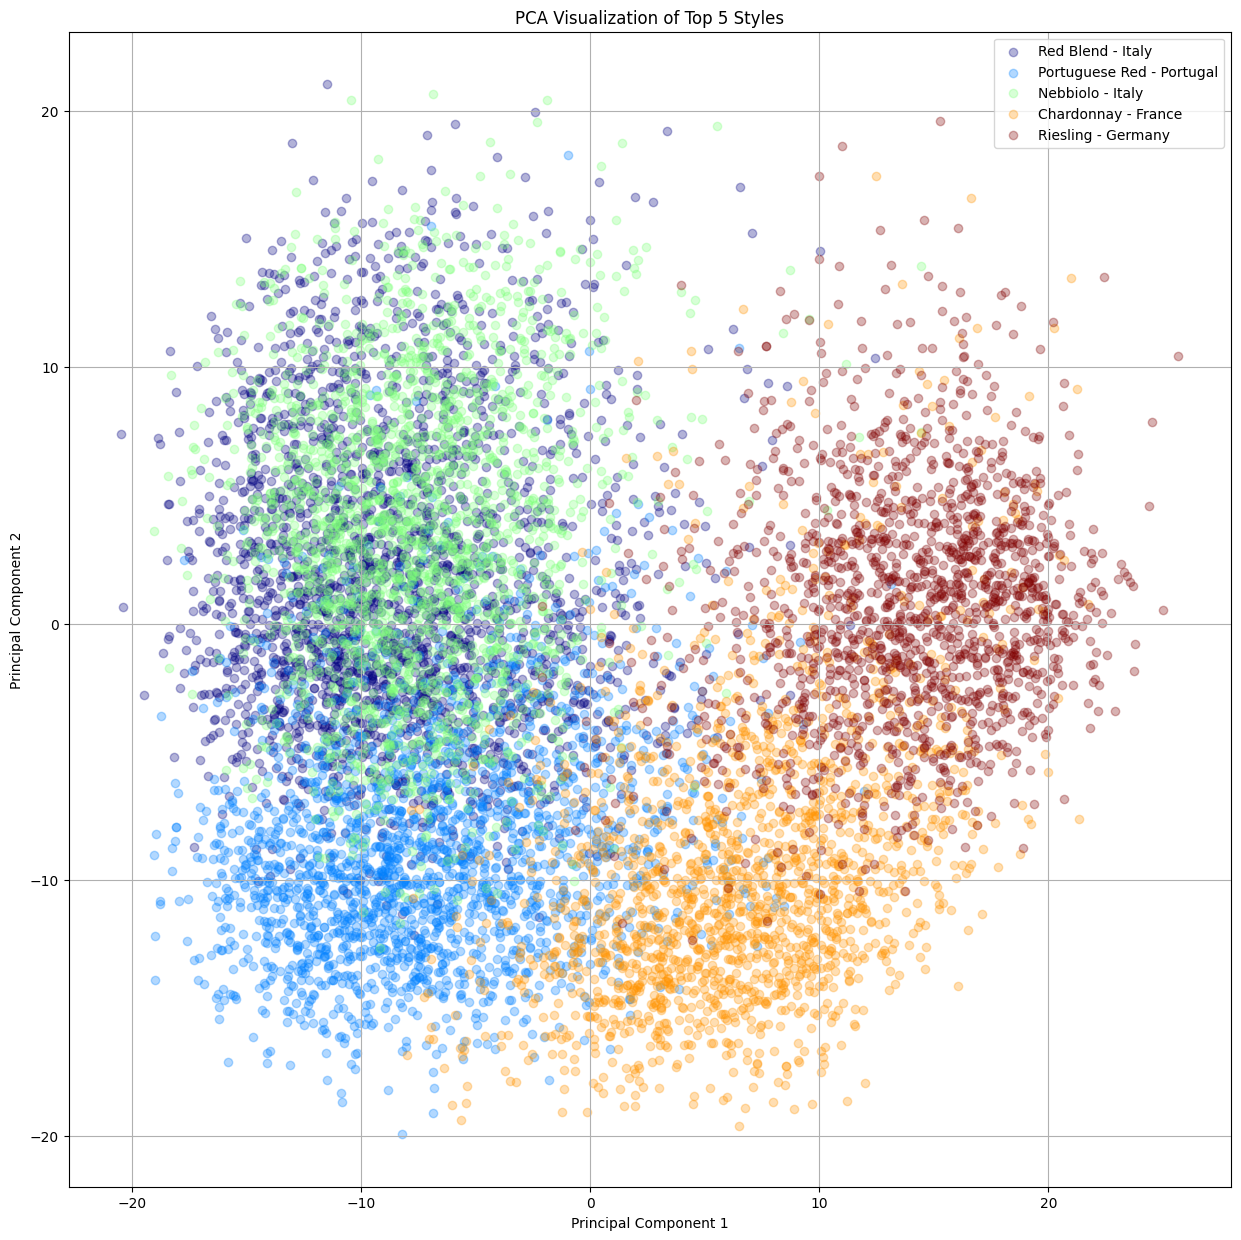

In [18]:
# get the style info
# Extract style information
style_labels = wine_rev_concat['style3'].tolist()

# Count the occurrences of each grape variety
style_counts = wine_rev_concat['style3'].value_counts()

# Get the n most common grape varieties here I have n=5
top_styles = style_counts.head(5).index.tolist()

# Filter the vectors, labels, and colors based on these top varieties
filtered_indices = [i for i, s in enumerate(wine_rev_concat['style3']) if s in top_styles]

filtered_vectors = transformed_vectors[filtered_indices]
filtered_styles= [style_labels[i] for i in filtered_indices]

# Assign a unique color to each of the top n grape varieties
colors = plt.cm.jet(np.linspace(0, 1, len(top_styles)))
color_map = dict(zip(top_styles, colors))
filtered_colors = [color_map[s] for s in filtered_styles]

# Visualize with a scatter plot
plt.figure(figsize=(15, 15))

# Scatter plot with color-coding by grape variety
for style, color in color_map.items():
    indices = [i for i, v in enumerate(filtered_styles) if v == style]
    plt.scatter(filtered_vectors[indices, 0], filtered_vectors[indices, 1], color=color, label=style, alpha=0.3)

plt.title("PCA Visualization of Top 5 Styles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
#plt.savefig("PCA_Top_5_styles.png", dpi=300, bbox_inches="tight")
plt.show()